### Readme
This code reads multiple nc files from RACMO data, reads topography values from RACMO icesheet mask, and applies binary mask to extract snowmelt data at surface elevation less than 2000m.
Final outcome is the spatial sum -> monthly time-series

In [ ]:
#while True:pass

### Read RACMO Snowmelt and Topography Data

In [ ]:
pip install netCDF4 regionmask

In [ ]:
import netCDF4
import matplotlib.pyplot as plt
import datetime
import sys
import numpy as np
import pandas as pd
from netCDF4 import Dataset

In [ ]:
import xarray as xr
import geopandas as gp
import regionmask
import shapefile as shp

### Creating Binary Mask from RACMO Topography Data

In [ ]:
file = '/content/snowmelt.1979_JAS.BN_RACMO2.3p2_FGRN055_1km.DD.nc'
file2 = '/content/Icemask_Topo_Iceclasses_lon_lat_average_1km.nc'
#file = '/content/ERA5land_snowmelt_JJA_1979_2021_monthly.nc'

df=Dataset(file,'r')
print(df.variables.keys()) # get all variable names

df2=Dataset(file2,'r')
print(df2.variables.keys()) # get all variable names

dict_keys(['time', 'x', 'y', 'LON', 'LAT', 'snowmeltcorr'])


In [ ]:
topo = np.array(df2.variables['Topography'][:])

In [ ]:
print(topo.shape)
np.save("RACMO_GrIS_1km_Topography.npy", topo)

(2700, 1496)


In [ ]:
cond1 = topo > 0
cond2 = topo < 2000 #ablation (melt) area can be found in regions lower than 2000m surface elevation
RACMO_ablation_area = np.where(cond1 & cond2, 1, 0)

In [ ]:
np.save("RACMO_GrIS_1km_Ablation_area_mask.npy", RACMO_ablation_area)

## Plotting for Verification

In [ ]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

#real_ice[0] == January 2014
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0))
cs = ax.coastlines(resolution='110m', linewidth=0.5)
ax.gridlines()
ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())
kw = dict(central_latitude=90, central_longitude=-45, true_scale_latitude=70)
cs = ax.pcolormesh(x, y, sm[2000], cmap=plt.cm.Blues_r,
                   transform=ccrs.Stereographic(**kw))
cbar = plt.colorbar(cs)
plt.title("Ablation Area")

### Reading one file of Data

In [ ]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import datetime

class ERA5_data(object):
    def __init__(self,fn):
        import netCDF4 as nc
        nc_fid = nc.Dataset(fn,'r')
        nc_fid.set_auto_mask(False)
        self.t0   = datetime.datetime(1979,1,1)
        self.time = nc_fid.variables['time'][:]
        hours = []
        for t in self.time:
            hours.append(self.t0 +  datetime.timedelta(float(t)))
        self.hours = hours
        self.lon  = nc_fid.variables['LON'][:]#['longitude'][:] #* units(?)
        self.lat  = nc_fid.variables['LAT'][:]#['latitude'][:] #* units(?)
        self.data = nc_fid.variables['snowmeltcorr'][:]
        #self.data = nc_fid.variables['smlt'][:]
        fill=nc_fid.variables['snowmeltcorr'].missing_value
        #fill=nc_fid.variables['smlt'].missing_value
        self.data[np.where(self.data==fill)]=np.nan

        nc_fid.close()

In [ ]:
ERA5 = ERA5_data('/content/snowmelt.1979_JAS.BN_RACMO2.3p2_FGRN055_1km.DD.nc')

print('number of hours:', len(ERA5.hours))
print('number of latitude points:', len(ERA5.lat))
print('number of longitude points:', len(ERA5.lon))
print('dimensions of the data',ERA5.data.shape)

number of hours: 92
number of latitude points: 2700
number of longitude points: 2700
dimensions of the data (92, 2700, 1496)


In [ ]:
#OPTIONAL: Creating time-series of RACMO ablation area mask
timesteps = len(ERA5.hours)
ablation_mask_ts = np.tile(RACMO_ablation_area,(timesteps,2700,1496))
abl_snow = np.multiply(ERA5.data, RACMO_ablation_area)

### Reading all NC files and combining data into one Numpy
Run this code on a server where all files are placed

In [ ]:
import xarray as xr
import numpy as np


path = "/umbc/rs/iharp/common/causality/data/greenland/racmo_data/*.nc" #replace with path where all files are kept
snow_data = xr.open_mfdataset(path, concat_dim = "time", chunks = "auto", combine = "nested",drop_variables =['time','x','y','LAT','LON'])
snow = np.array(snow_data.to_array()) #this creates one additional dimension at the beginning
snow = snow.reshape(3956, 2700, 1496) #reshape to get rid of the additional dimension, 3956 is the number of timesteps in combined data
np.save("/umbc/rs/iharp/common/causality/data/greenland/racmo_data/RACMO_snowmelt_JAS_daily_1979_2021.npy",snow)

### Taking Monthly Means of RACMO Data

In [ ]:
#Monthly Spatiotemporal Data
#Change data and storage path according to server

import numpy as np

data = np.load("/umbc/rs/iharp/common/causality/data/greenland/racmo_data/RACMO_snowmelt_daily_JJA_1979_2021.npy")
#Monthly Data
# Create lists of days per month
data = summer_days
months = [30, 31, 31]
month_lst = []

# Create a full list of days per month for each month in 1979-2021
for i in range(1979, 2022):
    month_lst.append(months)
month_lst = np.array(month_lst).reshape(-1)

# Iterate through each variable add to the final array.
final_arr = np.zeros((len(month_lst),2700, 1496))
var_idx = 0
for key in range(1):
	day_sum = 0
	var = data[:,:,:]
	var_arr = np.zeros((len(month_lst),2700, 1496))
	#print(var.shape)
	#print(var_arr.shape)
	for i in range(len(month_lst)):
		var_arr[i,:,:] = np.nanmean(var[day_sum:(day_sum + month_lst[i])], axis=0)
		if i % 3 == 0:
			print(day_sum)
		day_sum = day_sum + month_lst[i]
	day_sum = 0
	final_arr[:,:,:] = var_arr # Add variable monthly means to final array.
	var_idx += 1
print(final_arr.shape)

# Save final data array to a numpy array.
print(final_arr.shape)
monthly_data = np.save("/umbc/rs/iharp/common/causality/data/greenland/racmo_data/RACMO_snowmelt_monthly_JJA_1979_2021.npy",final_arr)

### Multiple monthly data with Topography mask
This will not need timeseries of mask

In [ ]:
snow_masked = np.array([np.multiply(snow[i,:,:],mask.reshape(1,2700,1496)) for i in range(129)])


### Take Spatial sum of data for getting Total Snowmelt

In [ ]:
tot_monthly_ts = np.array([np.nansum(snow_masked[i,:,:]) for i in range(129)])
print(tot_monthly_ts.shape)

### Store Monthly time-series

In [ ]:
np.save("/umbc/rs/iharp/common/causality/data/greenland/racmo_data/RACMO_snowmelt_JAS_monthly_ts_1979_2021.npy",tot_monthly_ts)

In [ ]:
import pandas as pd
dict = {'RACMO_snow':tot_monthly_ts}
data_m = pd.DataFrame(dict)
data_m.to_csv('/umbc/rs/iharp/common/causality/data/greenland/racmo_data/RACMO_snowmelt_JAS_monthly_ts_1979_2021.csv',header=True, index=False)

# Old Analysis

In [ ]:
#Extras
era5_lon = ERA5.lon
era5_lat = ERA5.lat

In [ ]:
GrIS_shp2 = gp.read_file('GRE_Basins_IMBIE2_v1.3.shp')
era5_GrIS_basin_mask2 = regionmask.mask_geopandas(GrIS_shp2['geometry'][2:],era5_lon, era5_lat, overlap=False)
print(GrIS_shp2.head(2))
#era5_GrIS_mask2 = xr.where(era5_GrIS_basin_mask2>0, 1, 0)#.values

  SUBREGION1                                           geometry
0    ICE_CAP  POLYGON ((-28.35064 71.11642, -28.33730 71.120...
1    ICE_CAP  POLYGON ((-21.74519 79.34692, -21.74365 79.347...


/usr/local/lib/python3.10/dist-packages/regionmask/core/_deprecate.py:108: UserWarning: No gridpoint belongs to any region. Returning an all-NaN mask.
  return func(*args, **kwargs)


In [ ]:
era5_GrIS_basin_mask2 = regionmask.mask_geopandas(GrIS_shp2[(GrIS_shp2.SUBREGION1=='NW') | (GrIS_shp2.SUBREGION1=='NE') | (GrIS_shp2.SUBREGION1=='SE') | (GrIS_shp2.SUBREGION1=='SW') | (GrIS_shp2.SUBREGION1=='CW') | (GrIS_shp2.SUBREGION1=='NO')]['geometry'], era5_lon, era5_lat) #Greenland subregions mask
era5_GrIS_mask2 = xr.where(era5_GrIS_basin_mask2>0, 1, 0)#only Greenland binary mask

/usr/local/lib/python3.10/dist-packages/regionmask/core/_deprecate.py:108: UserWarning: No gridpoint belongs to any region. Returning an all-NaN mask.
  return func(*args, **kwargs)


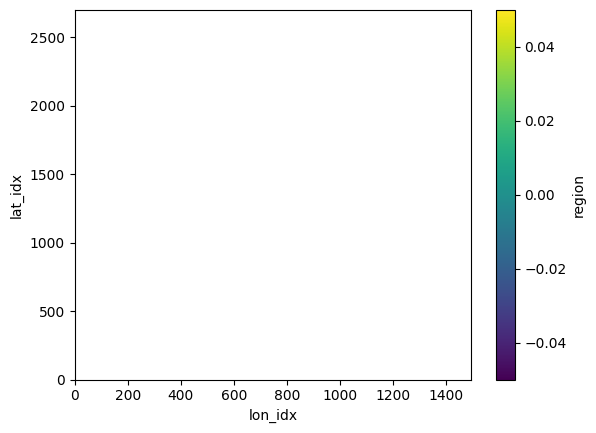

In [ ]:
era5_GrIS_basin_mask2.plot()

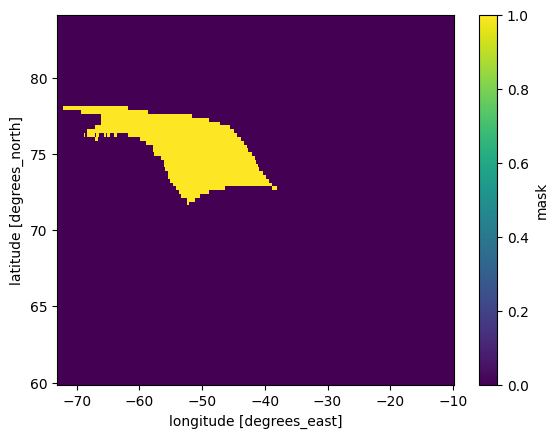

In [ ]:
era5_GrIS_mask3 = xr.where(era5_GrIS_basin_mask2==51, 1, 0)
era5_GrIS_mask3.plot();

### Storing Mask as Numpy

In [ ]:
era5_basin_mask = era5_GrIS_basin_mask2.to_numpy()

In [ ]:
era5_basin_mask.shape

(97, 253)

In [ ]:
m_basin_mask = np.tile(era5_basin_mask, (129, 1, 1)) #turn mask into time-series
print(m_basin_mask.shape)

(129, 97, 253)


In [ ]:
#Creating Regional Masks
nw = np.where(m_basin_mask == 51,1,0)#NW
cw = np.where(m_basin_mask == 52,1,0)#CW
sw = np.where(m_basin_mask == 53,1,0) #SW
se = np.where(m_basin_mask == 54,1,0) #SE
ne = np.where(m_basin_mask == 55,1,0)#NE
no = np.where(m_basin_mask == 56,1,0) #NO

In [ ]:
print(nw.shape)

(129, 97, 253)


## Dividing Data into Sub-regions

In [ ]:
## Reading data from numpy
temp = np.load('/content/ERA5_temp_700hPa_Greenland_Jun_Aug_1979_2021_monthly.npy')

In [ ]:
print(temp.shape)

(129, 97, 253)


In [ ]:
"""
#Reading data from NC
data_nw = np.copy(ERA5.data)
data_cw = np.copy(ERA5.data)
data_sw = np.copy(ERA5.data)
data_se = np.copy(ERA5.data)
data_ne = np.copy(ERA5.data)
data_no = np.copy(ERA5.data)
print(data_nw.shape)
"""

(129, 241, 631)


In [ ]:
#Reading data from numpy
data_nw = np.copy(temp)
data_cw = np.copy(temp)
data_sw = np.copy(temp)
data_se = np.copy(temp)
data_ne = np.copy(temp)
data_no = np.copy(temp)

In [ ]:
data_nw_masked = np.multiply(data_nw, nw)
data_cw_masked = np.multiply(data_cw, cw)
data_sw_masked = np.multiply(data_sw, sw)
data_se_masked = np.multiply(data_se, se)
data_ne_masked = np.multiply(data_ne, ne)
data_no_masked = np.multiply(data_no, no)

### Creating Regional Time-Series

Run this only for snowmelt data to calculate cumulative snow melt

In [ ]:
"""
tot_nw_data = np.array([np.nansum(data_nw_masked[i,:,:]) for i in range(129)])
tot_sw_data = np.array([np.nansum(data_sw_masked[i,:,:]) for i in range(129)])
tot_cw_data = np.array([np.nansum(data_cw_masked[i,:,:]) for i in range(129)])
tot_se_data = np.array([np.nansum(data_se_masked[i,:,:]) for i in range(129)])
tot_ne_data = np.array([np.nansum(data_ne_masked[i,:,:]) for i in range(129)])
tot_no_data = np.array([np.nansum(data_no_masked[i,:,:]) for i in range(129)])
"""

Run this for other temp data to calculate mean values

In [ ]:
tot_nw_data = np.array([np.nanmean(data_nw_masked[i,:,:]) for i in range(129)])
tot_sw_data = np.array([np.nanmean(data_sw_masked[i,:,:]) for i in range(129)])
tot_cw_data = np.array([np.nanmean(data_cw_masked[i,:,:]) for i in range(129)])
tot_se_data = np.array([np.nanmean(data_se_masked[i,:,:]) for i in range(129)])
tot_ne_data = np.array([np.nanmean(data_ne_masked[i,:,:]) for i in range(129)])
tot_no_data = np.array([np.nanmean(data_no_masked[i,:,:]) for i in range(129)])

In [ ]:
print(tot_nw_data)
print(tot_sw_data)
print(tot_cw_data)
print(tot_se_data)
print(tot_ne_data)
print(tot_no_data)

### Storing Regional Data

In [ ]:
"""
np.save('ERA5land_snowmelt_JJA_1979_2021_nw.npy',tot_nw_data)
np.save('ERA5land_snowmelt_JJA_1979_2021_sw.npy',tot_sw_data)
np.save('ERA5land_snowmelt_JJA_1979_2021_cw.npy',tot_cw_data)
np.save('ERA5land_snowmelt_JJA_1979_2021_ne.npy',tot_ne_data)
np.save('ERA5land_snowmelt_JJA_1979_2021_se.npy',tot_se_data)
np.save('ERA5land_snowmelt_JJA_1979_2021_no.npy',tot_no_data)
"""

In [ ]:
np.save('ERA5_700hPa_JJA_1979_2021_nw.npy',tot_nw_data)
np.save('ERA5_700hPa_JJA_1979_2021_sw.npy',tot_sw_data)
np.save('ERA5_700hPa_JJA_1979_2021_cw.npy',tot_cw_data)
np.save('ERA5_700hPa_JJA_1979_2021_ne.npy',tot_ne_data)
np.save('ERA5_700hPa_JJA_1979_2021_se.npy',tot_se_data)
np.save('ERA5_700hPa_JJA_1979_2021_no.npy',tot_no_data)

## Read Greenland basin boundaries

### (1) 7 basins

Reference: https://www.pnas.org/doi/10.1073/pnas.1904242116

In [ ]:
## Read basin boundaries
basin_boundaries = xr.open_dataset('/glade/work/ziqiyin/data/GrIS_7basins/Mouginot2019_basins_1km.nc')['Mouginot_basins']

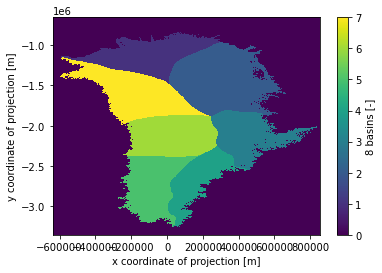

In [ ]:
basin_boundaries.plot();

### (2) 6 basins

Reference: http://imbie.org/imbie-3/drainage-basins/

In [ ]:
shp = gp.read_file('/glade/work/ziqiyin/data/GrIS_6basins/GRE_Basins_IMBIE2_v1.3.shp');

In [ ]:
# Read projection info for shapefile
shp.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
shp['geometry'][:]

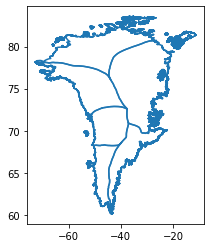

In [ ]:
shp.boundary.plot();

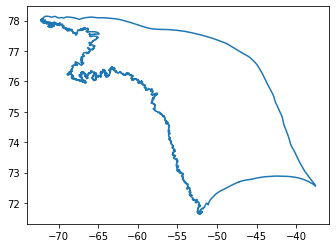

In [ ]:
shp[(shp.SUBREGION1=='NW')].boundary.plot();

## Combining Regional Time-Series

In [ ]:
#Loading GBI monthly data
df2 = pd.read_csv('/content/Greenland_GBI_SM_combined_JJA_monthly_1979_2021.csv')
df2.info()
gbi = np.array(df2)[:,3]
print(gbi.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temp_200hPa  129 non-null    float64
 1   Temp_500hPa  129 non-null    float64
 2   Temp_700hPa  129 non-null    float64
 3   GBI          129 non-null    float64
 4   SM           129 non-null    float64
dtypes: float64(5)
memory usage: 5.2 KB
(129,)


In [ ]:
t2m = np.load('ERA5_2mtemp_JJA_1979_2021_se.npy')
temp200 = np.load('ERA5_200hPa_JJA_1979_2021_se.npy')
temp500 = np.load('ERA5_500hPa_JJA_1979_2021_se.npy')
temp700 = np.load('ERA5_700hPa_JJA_1979_2021_se.npy')
smlt = np.load('ERA5land_snowmelt_JJA_1979_2021_se.npy')
dict={'Temp_2m':t2m,'Temp_200hPa':temp200,'Temp_500hPa':temp500,\
    'Temp_700hPa':temp700,'GBI':gbi,'SMLT':smlt}
data_m=pd.DataFrame(dict)
data_m.to_csv('GrIS_regional_SE_combined_JJA_monthly_1979_2021.csv',header=True,index=False)